# Date cleaning for SVI

- Allow multiple observation for the same moneyness on the same date

In [8]:
import pandas as pd
import numpy as np
import os


path = "/Users/irtg/Documents/Github/BTC-premia/SVI_independent_tau/"
os.chdir(path)

data_path = os.path.join(path, "Data", "processed","20172022_processed_1_3_4.csv")

# Load the dataset
df = pd.read_csv(data_path)

# Convert 'date' to datetime type for easy grouping
df['date'] = pd.to_datetime(df['date'])

# Data cleaning: Drop rows with IV <= 0 or tau < 3
df = df[(df['IV'] > 0) & (df['tau'] >= 3)]

# Filter out rows where 'quantity' is zero before applying aggregation
df = df[df['quantity'] > 0]

# Calculate the moneyness: moneyness = K/S - 1
df['moneyness'] = df['K'] / df['BTC_price'] - 1

# Initialize an empty list to store the ATM IV values for each date
iv_atm_list = []
# Iterate through each unique date and tau to find the ATM IV (where moneyness is closest to 0)
for (date, tau), group in df.groupby(['date', 'tau']):
    closest_row = group.iloc[(group['moneyness']).abs().argsort()[:1]]  # Closest row to moneyness = 0
    iv_atm = closest_row['IV'].values[0]
    moneyness_atm = closest_row['moneyness'].values[0]
    iv_atm_list.append({'date': date, 'tau': tau, 'IV_atm': iv_atm, 'moneyness_atm': moneyness_atm})

# Create a DataFrame from the ATM IV list
iv_atm_df = pd.DataFrame(iv_atm_list)

# Merge the ATM IV values back into the original dataframe
df = df.merge(iv_atm_df, on=['date', 'tau'], how='left')

# Calculate standardized moneyness: standardized_moneyness = (K/S - 1) / IV_atm
# Multiply by 100 for scaling
df['standardized_moneyness'] = df['moneyness']/ df['IV_atm'] * 100

# Save the result to a new CSV file
save_path = os.path.join(path, "data", "processed", "20172022_processed_1_3_6_standardized_moneyness_moneyness_not_unique.csv")
df.to_csv(save_path, index=False)

print("Standardized moneyness calculation completed and saved to '20172022_processed_1_3_6_standardized_moneyness_moneyness_not_unique.csv'")

# Save the ATM IV values to a new CSV file
save_path = os.path.join(path, "Data", "IV", "ATM", "20172022_ATM_IV.csv")
if not os.path.exists(os.path.dirname(save_path)):
    os.makedirs(os.path.dirname(save_path))
iv_atm_df.to_csv(save_path, index=False)

print("ATM IV values saved to '20172022_ATM_IV.csv'")



Standardized moneyness calculation completed and saved to '20172022_processed_1_3_6_standardized_moneyness_moneyness_not_unique.csv'
ATM IV values saved to '20172022_ATM_IV.csv'


## Visualize the ATM IV curves

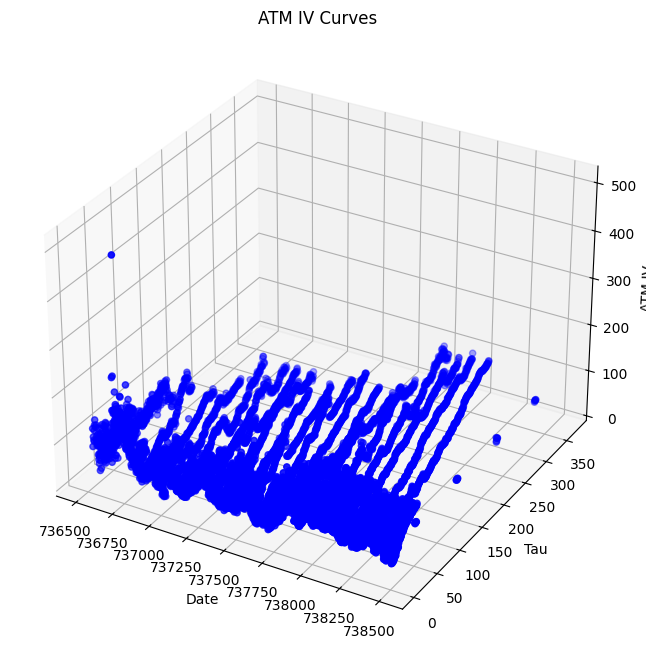

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Plotting the 3D graph of ATM IV curves
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Prepare data for plotting
x = iv_atm_df['date'].map(pd.Timestamp.toordinal) # Convert date to ordinal numbers
y = iv_atm_df['tau']
z = iv_atm_df['IV_atm']

# Plot the surface
ax.scatter(x, y, z, c='b', marker='o')

# Label the axes
ax.set_xlabel('Date')
ax.set_ylabel('Tau')
ax.set_zlabel('ATM IV')
ax.set_title('ATM IV Curves')

# Show the plot
plt.show()

## Report the observations for each day

In [10]:
# Create a new DataFrame with 'date' and 'observations' (number of rows per date)
observations_df = df.groupby('date').size().reset_index(name='observations')

# Save the observations DataFrame to a new CSV file
observations_save_path = os.path.join(path, "Data", "processed", "20172022_processed_1_3_6_1_observations.csv")
observations_df.to_csv(observations_save_path, index=False)

print("Observations per date saved to '20172022_processed_1_3_6_1_observations.csv'")


Observations per date saved to '20172022_processed_1_3_6_1_observations.csv'


In [11]:
print("The size of df is:", df.shape)

The size of df is: (5384537, 16)


## Create folders for moneyness and standardized moneyness

In [12]:
print(df)

              date  BTC_price  option_price  tau      K     IV  quantity  \
0       2017-07-01    2485.09        771.12   90   1800  75.99      1.00   
1       2017-07-01    2497.86        625.46   90   2000  71.64      1.00   
2       2017-07-01    2436.94        326.55   27   2300  98.15      0.01   
3       2017-07-01    2464.55        330.25   27   2300  92.33      1.00   
4       2017-07-01    2433.63        326.11   27   2300  98.67      0.20   
...            ...        ...           ...  ...    ...    ...       ...   
5384532 2022-12-13   17909.12        385.05    3  18000  52.81      1.00   
5384533 2022-12-13   17907.79        385.02    3  18000  52.69      1.00   
5384534 2022-12-13   17907.77        385.02    3  18000  52.68      1.00   
5384535 2022-12-13   17723.71        478.54    3  18000  54.71      0.10   
5384536 2022-12-13   17723.71        478.54    3  18000  54.71      1.00   

        putcall      volume  moneyness  volume_optionprice tau_range  \
0             C

In [13]:
moneyness_folder = os.path.join(path, "IV", "IV_raw", "duplicate", "moneyness")
standardized_moneyness_folder = os.path.join(path, "IV", "IV_raw", "duplicate", "standardized_moneyness")

if not os.path.exists(moneyness_folder):
    os.makedirs(moneyness_folder)

if not os.path.exists(standardized_moneyness_folder):
    os.makedirs(standardized_moneyness_folder)

# Handle moneyness with duplicate adjustment
def adjust_moneyness(group):
    group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
    group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
    return group

# Handle standardized moneyness with duplicate adjustment
def adjust_standardized_moneyness(group):
        group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
        group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
        return group

# Iterate through each unique date to create dataframes for moneyness and standardized moneyness
for date, group in df.groupby('date'):
    # Aggregate by taking the mean of IV values
    moneyness_df = adjust_moneyness(group[['moneyness', 'tau', 'IV']])
    moneyness_pivot = moneyness_df.pivot(index='moneyness', columns='tau', values='IV').reset_index()
    moneyness_file_path = os.path.join(moneyness_folder, f"IV_matrix_{date.strftime('%Y-%m-%d')}.csv")
    moneyness_pivot.to_csv(moneyness_file_path, index=False)

    # Aggregate by taking the mean of IV values
    standardized_moneyness_df = adjust_standardized_moneyness(group[['standardized_moneyness', 'tau', 'IV']])
    standardized_moneyness_pivot = standardized_moneyness_df.pivot(index='standardized_moneyness', columns='tau', values='IV').reset_index()
    standardized_moneyness_file_path = os.path.join(standardized_moneyness_folder, f"IV_matrix_{date.strftime('%Y-%m-%d')}.csv")
    standardized_moneyness_pivot.to_csv(standardized_moneyness_file_path, index=False)

    print(f"Moneyness and standardized moneyness dataframes saved for date {date.strftime('%Y-%m-%d')}")


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2017-07-01
Moneyness and standardized moneyness dataframes saved for date 2017-07-02
Moneyness and standardized moneyness dataframes saved for date 2017-07-03
Moneyness and standardized moneyness dataframes saved for date 2017-07-04
Moneyness and standardized moneyness dataframes saved for date 2017-07-05
Moneyness and standardized moneyness dataframes saved for date 2017-07-06
Moneyness and standardized moneyness dataframes saved for date 2017-07-07
Moneyness and standardized moneyness dataframes saved for date 2017-07-08
Moneyness and standardized moneyness dataframes saved for date 2017-07-09
Moneyness and standardized moneyness dataframes saved for date 2017-07-10
Moneyness and standardized moneyness dataframes saved for date 2017-07-11
Moneyness and standardized moneyness dataframes saved for date 2017-07-12
Moneyness and standardized moneyness dataframes saved for date 2017-07-13
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2017-09-21
Moneyness and standardized moneyness dataframes saved for date 2017-09-22
Moneyness and standardized moneyness dataframes saved for date 2017-09-23
Moneyness and standardized moneyness dataframes saved for date 2017-09-24
Moneyness and standardized moneyness dataframes saved for date 2017-09-25
Moneyness and standardized moneyness dataframes saved for date 2017-09-26
Moneyness and standardized moneyness dataframes saved for date 2017-09-27
Moneyness and standardized moneyness dataframes saved for date 2017-09-28
Moneyness and standardized moneyness dataframes saved for date 2017-09-29
Moneyness and standardized moneyness dataframes saved for date 2017-09-30
Moneyness and standardized moneyness dataframes saved for date 2017-10-01
Moneyness and standardized moneyness dataframes saved for date 2017-10-02
Moneyness and standardized moneyness dataframes saved for date 2017-10-03
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2017-11-29
Moneyness and standardized moneyness dataframes saved for date 2017-11-30
Moneyness and standardized moneyness dataframes saved for date 2017-12-01
Moneyness and standardized moneyness dataframes saved for date 2017-12-02
Moneyness and standardized moneyness dataframes saved for date 2017-12-03
Moneyness and standardized moneyness dataframes saved for date 2017-12-04
Moneyness and standardized moneyness dataframes saved for date 2017-12-05
Moneyness and standardized moneyness dataframes saved for date 2017-12-06
Moneyness and standardized moneyness dataframes saved for date 2017-12-07
Moneyness and standardized moneyness dataframes saved for date 2017-12-08
Moneyness and standardized moneyness dataframes saved for date 2017-12-09
Moneyness and standardized moneyness dataframes saved for date 2017-12-10
Moneyness and standardized moneyness dataframes saved for date 2017-12-11
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2018-01-29
Moneyness and standardized moneyness dataframes saved for date 2018-01-30
Moneyness and standardized moneyness dataframes saved for date 2018-01-31
Moneyness and standardized moneyness dataframes saved for date 2018-02-01
Moneyness and standardized moneyness dataframes saved for date 2018-02-02
Moneyness and standardized moneyness dataframes saved for date 2018-02-03
Moneyness and standardized moneyness dataframes saved for date 2018-02-04
Moneyness and standardized moneyness dataframes saved for date 2018-02-05
Moneyness and standardized moneyness dataframes saved for date 2018-02-06
Moneyness and standardized moneyness dataframes saved for date 2018-02-07
Moneyness and standardized moneyness dataframes saved for date 2018-02-08
Moneyness and standardized moneyness dataframes saved for date 2018-02-09
Moneyness and standardized moneyness dataframes saved for date 2018-02-10
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2018-03-24
Moneyness and standardized moneyness dataframes saved for date 2018-03-25
Moneyness and standardized moneyness dataframes saved for date 2018-03-26
Moneyness and standardized moneyness dataframes saved for date 2018-03-27
Moneyness and standardized moneyness dataframes saved for date 2018-03-28
Moneyness and standardized moneyness dataframes saved for date 2018-03-29
Moneyness and standardized moneyness dataframes saved for date 2018-03-30
Moneyness and standardized moneyness dataframes saved for date 2018-03-31
Moneyness and standardized moneyness dataframes saved for date 2018-04-01
Moneyness and standardized moneyness dataframes saved for date 2018-04-02
Moneyness and standardized moneyness dataframes saved for date 2018-04-03
Moneyness and standardized moneyness dataframes saved for date 2018-04-04
Moneyness and standardized moneyness dataframes saved for date 2018-04-05
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2018-05-26
Moneyness and standardized moneyness dataframes saved for date 2018-05-27
Moneyness and standardized moneyness dataframes saved for date 2018-05-28
Moneyness and standardized moneyness dataframes saved for date 2018-05-29
Moneyness and standardized moneyness dataframes saved for date 2018-05-30
Moneyness and standardized moneyness dataframes saved for date 2018-05-31
Moneyness and standardized moneyness dataframes saved for date 2018-06-01
Moneyness and standardized moneyness dataframes saved for date 2018-06-02
Moneyness and standardized moneyness dataframes saved for date 2018-06-03
Moneyness and standardized moneyness dataframes saved for date 2018-06-04
Moneyness and standardized moneyness dataframes saved for date 2018-06-05
Moneyness and standardized moneyness dataframes saved for date 2018-06-06
Moneyness and standardized moneyness dataframes saved for date 2018-06-07
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2018-07-28
Moneyness and standardized moneyness dataframes saved for date 2018-07-29
Moneyness and standardized moneyness dataframes saved for date 2018-07-30
Moneyness and standardized moneyness dataframes saved for date 2018-07-31
Moneyness and standardized moneyness dataframes saved for date 2018-08-01
Moneyness and standardized moneyness dataframes saved for date 2018-08-02
Moneyness and standardized moneyness dataframes saved for date 2018-08-03
Moneyness and standardized moneyness dataframes saved for date 2018-08-04
Moneyness and standardized moneyness dataframes saved for date 2018-08-05
Moneyness and standardized moneyness dataframes saved for date 2018-08-06
Moneyness and standardized moneyness dataframes saved for date 2018-08-07
Moneyness and standardized moneyness dataframes saved for date 2018-08-08
Moneyness and standardized moneyness dataframes saved for date 2018-08-09
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2018-09-22
Moneyness and standardized moneyness dataframes saved for date 2018-09-23
Moneyness and standardized moneyness dataframes saved for date 2018-09-24
Moneyness and standardized moneyness dataframes saved for date 2018-09-25
Moneyness and standardized moneyness dataframes saved for date 2018-09-26
Moneyness and standardized moneyness dataframes saved for date 2018-09-27
Moneyness and standardized moneyness dataframes saved for date 2018-09-28
Moneyness and standardized moneyness dataframes saved for date 2018-09-29
Moneyness and standardized moneyness dataframes saved for date 2018-09-30
Moneyness and standardized moneyness dataframes saved for date 2018-10-01
Moneyness and standardized moneyness dataframes saved for date 2018-10-02
Moneyness and standardized moneyness dataframes saved for date 2018-10-03
Moneyness and standardized moneyness dataframes saved for date 2018-10-04
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2018-11-02
Moneyness and standardized moneyness dataframes saved for date 2018-11-03
Moneyness and standardized moneyness dataframes saved for date 2018-11-04
Moneyness and standardized moneyness dataframes saved for date 2018-11-05
Moneyness and standardized moneyness dataframes saved for date 2018-11-06
Moneyness and standardized moneyness dataframes saved for date 2018-11-07
Moneyness and standardized moneyness dataframes saved for date 2018-11-08
Moneyness and standardized moneyness dataframes saved for date 2018-11-09
Moneyness and standardized moneyness dataframes saved for date 2018-11-10
Moneyness and standardized moneyness dataframes saved for date 2018-11-11
Moneyness and standardized moneyness dataframes saved for date 2018-11-12
Moneyness and standardized moneyness dataframes saved for date 2018-11-13
Moneyness and standardized moneyness dataframes saved for date 2018-11-14
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2019-02-07
Moneyness and standardized moneyness dataframes saved for date 2019-02-08
Moneyness and standardized moneyness dataframes saved for date 2019-02-09
Moneyness and standardized moneyness dataframes saved for date 2019-02-10
Moneyness and standardized moneyness dataframes saved for date 2019-02-11
Moneyness and standardized moneyness dataframes saved for date 2019-02-12
Moneyness and standardized moneyness dataframes saved for date 2019-02-13
Moneyness and standardized moneyness dataframes saved for date 2019-02-14
Moneyness and standardized moneyness dataframes saved for date 2019-02-15
Moneyness and standardized moneyness dataframes saved for date 2019-02-16
Moneyness and standardized moneyness dataframes saved for date 2019-02-17
Moneyness and standardized moneyness dataframes saved for date 2019-02-18
Moneyness and standardized moneyness dataframes saved for date 2019-02-19
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2019-03-18
Moneyness and standardized moneyness dataframes saved for date 2019-03-19
Moneyness and standardized moneyness dataframes saved for date 2019-03-20
Moneyness and standardized moneyness dataframes saved for date 2019-03-21
Moneyness and standardized moneyness dataframes saved for date 2019-03-22
Moneyness and standardized moneyness dataframes saved for date 2019-03-23
Moneyness and standardized moneyness dataframes saved for date 2019-03-24
Moneyness and standardized moneyness dataframes saved for date 2019-03-25
Moneyness and standardized moneyness dataframes saved for date 2019-03-26
Moneyness and standardized moneyness dataframes saved for date 2019-03-27
Moneyness and standardized moneyness dataframes saved for date 2019-03-28
Moneyness and standardized moneyness dataframes saved for date 2019-03-29
Moneyness and standardized moneyness dataframes saved for date 2019-03-30
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2019-05-01
Moneyness and standardized moneyness dataframes saved for date 2019-05-02
Moneyness and standardized moneyness dataframes saved for date 2019-05-03
Moneyness and standardized moneyness dataframes saved for date 2019-05-04
Moneyness and standardized moneyness dataframes saved for date 2019-05-05
Moneyness and standardized moneyness dataframes saved for date 2019-05-06
Moneyness and standardized moneyness dataframes saved for date 2019-05-07
Moneyness and standardized moneyness dataframes saved for date 2019-05-08
Moneyness and standardized moneyness dataframes saved for date 2019-05-09
Moneyness and standardized moneyness dataframes saved for date 2019-05-10
Moneyness and standardized moneyness dataframes saved for date 2019-05-11
Moneyness and standardized moneyness dataframes saved for date 2019-05-12
Moneyness and standardized moneyness dataframes saved for date 2019-05-13
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2019-06-03
Moneyness and standardized moneyness dataframes saved for date 2019-06-04
Moneyness and standardized moneyness dataframes saved for date 2019-06-05
Moneyness and standardized moneyness dataframes saved for date 2019-06-06
Moneyness and standardized moneyness dataframes saved for date 2019-06-07
Moneyness and standardized moneyness dataframes saved for date 2019-06-08
Moneyness and standardized moneyness dataframes saved for date 2019-06-09
Moneyness and standardized moneyness dataframes saved for date 2019-06-10
Moneyness and standardized moneyness dataframes saved for date 2019-06-11
Moneyness and standardized moneyness dataframes saved for date 2019-06-12
Moneyness and standardized moneyness dataframes saved for date 2019-06-13
Moneyness and standardized moneyness dataframes saved for date 2019-06-14
Moneyness and standardized moneyness dataframes saved for date 2019-06-15
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2019-07-06
Moneyness and standardized moneyness dataframes saved for date 2019-07-07
Moneyness and standardized moneyness dataframes saved for date 2019-07-08
Moneyness and standardized moneyness dataframes saved for date 2019-07-09
Moneyness and standardized moneyness dataframes saved for date 2019-07-10
Moneyness and standardized moneyness dataframes saved for date 2019-07-11
Moneyness and standardized moneyness dataframes saved for date 2019-07-12
Moneyness and standardized moneyness dataframes saved for date 2019-07-13
Moneyness and standardized moneyness dataframes saved for date 2019-07-14
Moneyness and standardized moneyness dataframes saved for date 2019-07-15
Moneyness and standardized moneyness dataframes saved for date 2019-07-16
Moneyness and standardized moneyness dataframes saved for date 2019-07-17
Moneyness and standardized moneyness dataframes saved for date 2019-07-18
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2019-08-09
Moneyness and standardized moneyness dataframes saved for date 2019-08-10
Moneyness and standardized moneyness dataframes saved for date 2019-08-11
Moneyness and standardized moneyness dataframes saved for date 2019-08-12
Moneyness and standardized moneyness dataframes saved for date 2019-08-13
Moneyness and standardized moneyness dataframes saved for date 2019-08-14
Moneyness and standardized moneyness dataframes saved for date 2019-08-15
Moneyness and standardized moneyness dataframes saved for date 2019-08-16
Moneyness and standardized moneyness dataframes saved for date 2019-08-17
Moneyness and standardized moneyness dataframes saved for date 2019-08-18
Moneyness and standardized moneyness dataframes saved for date 2019-08-19
Moneyness and standardized moneyness dataframes saved for date 2019-08-20
Moneyness and standardized moneyness dataframes saved for date 2019-08-21
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2019-09-15
Moneyness and standardized moneyness dataframes saved for date 2019-09-16
Moneyness and standardized moneyness dataframes saved for date 2019-09-17
Moneyness and standardized moneyness dataframes saved for date 2019-09-18
Moneyness and standardized moneyness dataframes saved for date 2019-09-19
Moneyness and standardized moneyness dataframes saved for date 2019-09-20
Moneyness and standardized moneyness dataframes saved for date 2019-09-21
Moneyness and standardized moneyness dataframes saved for date 2019-09-22
Moneyness and standardized moneyness dataframes saved for date 2019-09-23
Moneyness and standardized moneyness dataframes saved for date 2019-09-24
Moneyness and standardized moneyness dataframes saved for date 2019-09-25
Moneyness and standardized moneyness dataframes saved for date 2019-09-26
Moneyness and standardized moneyness dataframes saved for date 2019-09-27
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2019-10-14
Moneyness and standardized moneyness dataframes saved for date 2019-10-15
Moneyness and standardized moneyness dataframes saved for date 2019-10-16
Moneyness and standardized moneyness dataframes saved for date 2019-10-17
Moneyness and standardized moneyness dataframes saved for date 2019-10-18
Moneyness and standardized moneyness dataframes saved for date 2019-10-19
Moneyness and standardized moneyness dataframes saved for date 2019-10-20
Moneyness and standardized moneyness dataframes saved for date 2019-10-21
Moneyness and standardized moneyness dataframes saved for date 2019-10-22
Moneyness and standardized moneyness dataframes saved for date 2019-10-23
Moneyness and standardized moneyness dataframes saved for date 2019-10-24
Moneyness and standardized moneyness dataframes saved for date 2019-10-25
Moneyness and standardized moneyness dataframes saved for date 2019-10-26
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2019-11-09
Moneyness and standardized moneyness dataframes saved for date 2019-11-10
Moneyness and standardized moneyness dataframes saved for date 2019-11-11
Moneyness and standardized moneyness dataframes saved for date 2019-11-12
Moneyness and standardized moneyness dataframes saved for date 2019-11-13
Moneyness and standardized moneyness dataframes saved for date 2019-11-14
Moneyness and standardized moneyness dataframes saved for date 2019-11-15
Moneyness and standardized moneyness dataframes saved for date 2019-11-16
Moneyness and standardized moneyness dataframes saved for date 2019-11-17
Moneyness and standardized moneyness dataframes saved for date 2019-11-18
Moneyness and standardized moneyness dataframes saved for date 2019-11-19
Moneyness and standardized moneyness dataframes saved for date 2019-11-20
Moneyness and standardized moneyness dataframes saved for date 2019-11-21
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2019-12-03
Moneyness and standardized moneyness dataframes saved for date 2019-12-04
Moneyness and standardized moneyness dataframes saved for date 2019-12-05
Moneyness and standardized moneyness dataframes saved for date 2019-12-06
Moneyness and standardized moneyness dataframes saved for date 2019-12-07
Moneyness and standardized moneyness dataframes saved for date 2019-12-08
Moneyness and standardized moneyness dataframes saved for date 2019-12-09
Moneyness and standardized moneyness dataframes saved for date 2019-12-10
Moneyness and standardized moneyness dataframes saved for date 2019-12-11
Moneyness and standardized moneyness dataframes saved for date 2019-12-12
Moneyness and standardized moneyness dataframes saved for date 2019-12-13
Moneyness and standardized moneyness dataframes saved for date 2019-12-14
Moneyness and standardized moneyness dataframes saved for date 2019-12-15
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-01-23
Moneyness and standardized moneyness dataframes saved for date 2020-01-24
Moneyness and standardized moneyness dataframes saved for date 2020-01-25
Moneyness and standardized moneyness dataframes saved for date 2020-01-26
Moneyness and standardized moneyness dataframes saved for date 2020-01-27
Moneyness and standardized moneyness dataframes saved for date 2020-01-28
Moneyness and standardized moneyness dataframes saved for date 2020-01-29
Moneyness and standardized moneyness dataframes saved for date 2020-01-30
Moneyness and standardized moneyness dataframes saved for date 2020-01-31
Moneyness and standardized moneyness dataframes saved for date 2020-02-01
Moneyness and standardized moneyness dataframes saved for date 2020-02-02
Moneyness and standardized moneyness dataframes saved for date 2020-02-03
Moneyness and standardized moneyness dataframes saved for date 2020-02-04
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-02-14
Moneyness and standardized moneyness dataframes saved for date 2020-02-15
Moneyness and standardized moneyness dataframes saved for date 2020-02-16
Moneyness and standardized moneyness dataframes saved for date 2020-02-17
Moneyness and standardized moneyness dataframes saved for date 2020-02-18
Moneyness and standardized moneyness dataframes saved for date 2020-02-19
Moneyness and standardized moneyness dataframes saved for date 2020-02-20
Moneyness and standardized moneyness dataframes saved for date 2020-02-21
Moneyness and standardized moneyness dataframes saved for date 2020-02-22
Moneyness and standardized moneyness dataframes saved for date 2020-02-23
Moneyness and standardized moneyness dataframes saved for date 2020-02-24
Moneyness and standardized moneyness dataframes saved for date 2020-02-25
Moneyness and standardized moneyness dataframes saved for date 2020-02-26
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-03-07
Moneyness and standardized moneyness dataframes saved for date 2020-03-08
Moneyness and standardized moneyness dataframes saved for date 2020-03-09
Moneyness and standardized moneyness dataframes saved for date 2020-03-10
Moneyness and standardized moneyness dataframes saved for date 2020-03-11
Moneyness and standardized moneyness dataframes saved for date 2020-03-12
Moneyness and standardized moneyness dataframes saved for date 2020-03-13
Moneyness and standardized moneyness dataframes saved for date 2020-03-14
Moneyness and standardized moneyness dataframes saved for date 2020-03-15
Moneyness and standardized moneyness dataframes saved for date 2020-03-16
Moneyness and standardized moneyness dataframes saved for date 2020-03-17
Moneyness and standardized moneyness dataframes saved for date 2020-03-18
Moneyness and standardized moneyness dataframes saved for date 2020-03-19
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-03-27
Moneyness and standardized moneyness dataframes saved for date 2020-03-28
Moneyness and standardized moneyness dataframes saved for date 2020-03-29
Moneyness and standardized moneyness dataframes saved for date 2020-03-30
Moneyness and standardized moneyness dataframes saved for date 2020-03-31
Moneyness and standardized moneyness dataframes saved for date 2020-04-01
Moneyness and standardized moneyness dataframes saved for date 2020-04-02
Moneyness and standardized moneyness dataframes saved for date 2020-04-03
Moneyness and standardized moneyness dataframes saved for date 2020-04-04
Moneyness and standardized moneyness dataframes saved for date 2020-04-05
Moneyness and standardized moneyness dataframes saved for date 2020-04-06
Moneyness and standardized moneyness dataframes saved for date 2020-04-07
Moneyness and standardized moneyness dataframes saved for date 2020-04-08
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-04-11
Moneyness and standardized moneyness dataframes saved for date 2020-04-12
Moneyness and standardized moneyness dataframes saved for date 2020-04-13
Moneyness and standardized moneyness dataframes saved for date 2020-04-14
Moneyness and standardized moneyness dataframes saved for date 2020-04-15
Moneyness and standardized moneyness dataframes saved for date 2020-04-16
Moneyness and standardized moneyness dataframes saved for date 2020-04-17
Moneyness and standardized moneyness dataframes saved for date 2020-04-18
Moneyness and standardized moneyness dataframes saved for date 2020-04-19
Moneyness and standardized moneyness dataframes saved for date 2020-04-20
Moneyness and standardized moneyness dataframes saved for date 2020-04-21
Moneyness and standardized moneyness dataframes saved for date 2020-04-22
Moneyness and standardized moneyness dataframes saved for date 2020-04-23
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-04-27
Moneyness and standardized moneyness dataframes saved for date 2020-04-28
Moneyness and standardized moneyness dataframes saved for date 2020-04-29
Moneyness and standardized moneyness dataframes saved for date 2020-04-30
Moneyness and standardized moneyness dataframes saved for date 2020-05-01
Moneyness and standardized moneyness dataframes saved for date 2020-05-02
Moneyness and standardized moneyness dataframes saved for date 2020-05-03
Moneyness and standardized moneyness dataframes saved for date 2020-05-04
Moneyness and standardized moneyness dataframes saved for date 2020-05-05
Moneyness and standardized moneyness dataframes saved for date 2020-05-06
Moneyness and standardized moneyness dataframes saved for date 2020-05-07
Moneyness and standardized moneyness dataframes saved for date 2020-05-08


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-05-09
Moneyness and standardized moneyness dataframes saved for date 2020-05-10
Moneyness and standardized moneyness dataframes saved for date 2020-05-11
Moneyness and standardized moneyness dataframes saved for date 2020-05-12
Moneyness and standardized moneyness dataframes saved for date 2020-05-13
Moneyness and standardized moneyness dataframes saved for date 2020-05-14
Moneyness and standardized moneyness dataframes saved for date 2020-05-15
Moneyness and standardized moneyness dataframes saved for date 2020-05-16
Moneyness and standardized moneyness dataframes saved for date 2020-05-17
Moneyness and standardized moneyness dataframes saved for date 2020-05-18


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-05-19
Moneyness and standardized moneyness dataframes saved for date 2020-05-20
Moneyness and standardized moneyness dataframes saved for date 2020-05-21
Moneyness and standardized moneyness dataframes saved for date 2020-05-22
Moneyness and standardized moneyness dataframes saved for date 2020-05-23
Moneyness and standardized moneyness dataframes saved for date 2020-05-24
Moneyness and standardized moneyness dataframes saved for date 2020-05-25
Moneyness and standardized moneyness dataframes saved for date 2020-05-26
Moneyness and standardized moneyness dataframes saved for date 2020-05-27
Moneyness and standardized moneyness dataframes saved for date 2020-05-28
Moneyness and standardized moneyness dataframes saved for date 2020-05-29
Moneyness and standardized moneyness dataframes saved for date 2020-05-30
Moneyness and standardized moneyness dataframes saved for date 2020-05-31


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-06-01
Moneyness and standardized moneyness dataframes saved for date 2020-06-02
Moneyness and standardized moneyness dataframes saved for date 2020-06-03
Moneyness and standardized moneyness dataframes saved for date 2020-06-04
Moneyness and standardized moneyness dataframes saved for date 2020-06-05
Moneyness and standardized moneyness dataframes saved for date 2020-06-06
Moneyness and standardized moneyness dataframes saved for date 2020-06-07
Moneyness and standardized moneyness dataframes saved for date 2020-06-08
Moneyness and standardized moneyness dataframes saved for date 2020-06-09
Moneyness and standardized moneyness dataframes saved for date 2020-06-10
Moneyness and standardized moneyness dataframes saved for date 2020-06-11
Moneyness and standardized moneyness dataframes saved for date 2020-06-12
Moneyness and standardized moneyness dataframes saved for date 2020-06-13
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-06-15
Moneyness and standardized moneyness dataframes saved for date 2020-06-16
Moneyness and standardized moneyness dataframes saved for date 2020-06-17
Moneyness and standardized moneyness dataframes saved for date 2020-06-18
Moneyness and standardized moneyness dataframes saved for date 2020-06-19
Moneyness and standardized moneyness dataframes saved for date 2020-06-20
Moneyness and standardized moneyness dataframes saved for date 2020-06-21
Moneyness and standardized moneyness dataframes saved for date 2020-06-22
Moneyness and standardized moneyness dataframes saved for date 2020-06-23
Moneyness and standardized moneyness dataframes saved for date 2020-06-24
Moneyness and standardized moneyness dataframes saved for date 2020-06-25
Moneyness and standardized moneyness dataframes saved for date 2020-06-26
Moneyness and standardized moneyness dataframes saved for date 2020-06-27
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-06-29
Moneyness and standardized moneyness dataframes saved for date 2020-06-30
Moneyness and standardized moneyness dataframes saved for date 2020-07-01
Moneyness and standardized moneyness dataframes saved for date 2020-07-02
Moneyness and standardized moneyness dataframes saved for date 2020-07-03
Moneyness and standardized moneyness dataframes saved for date 2020-07-04
Moneyness and standardized moneyness dataframes saved for date 2020-07-05
Moneyness and standardized moneyness dataframes saved for date 2020-07-06
Moneyness and standardized moneyness dataframes saved for date 2020-07-07
Moneyness and standardized moneyness dataframes saved for date 2020-07-08
Moneyness and standardized moneyness dataframes saved for date 2020-07-09
Moneyness and standardized moneyness dataframes saved for date 2020-07-10
Moneyness and standardized moneyness dataframes saved for date 2020-07-11
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-07-13
Moneyness and standardized moneyness dataframes saved for date 2020-07-14
Moneyness and standardized moneyness dataframes saved for date 2020-07-15
Moneyness and standardized moneyness dataframes saved for date 2020-07-16
Moneyness and standardized moneyness dataframes saved for date 2020-07-17
Moneyness and standardized moneyness dataframes saved for date 2020-07-18
Moneyness and standardized moneyness dataframes saved for date 2020-07-19
Moneyness and standardized moneyness dataframes saved for date 2020-07-20
Moneyness and standardized moneyness dataframes saved for date 2020-07-21
Moneyness and standardized moneyness dataframes saved for date 2020-07-22
Moneyness and standardized moneyness dataframes saved for date 2020-07-23
Moneyness and standardized moneyness dataframes saved for date 2020-07-24
Moneyness and standardized moneyness dataframes saved for date 2020-07-25


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-07-26
Moneyness and standardized moneyness dataframes saved for date 2020-07-27
Moneyness and standardized moneyness dataframes saved for date 2020-07-28
Moneyness and standardized moneyness dataframes saved for date 2020-07-29
Moneyness and standardized moneyness dataframes saved for date 2020-07-30
Moneyness and standardized moneyness dataframes saved for date 2020-07-31
Moneyness and standardized moneyness dataframes saved for date 2020-08-01


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-08-02
Moneyness and standardized moneyness dataframes saved for date 2020-08-03
Moneyness and standardized moneyness dataframes saved for date 2020-08-04
Moneyness and standardized moneyness dataframes saved for date 2020-08-05
Moneyness and standardized moneyness dataframes saved for date 2020-08-06
Moneyness and standardized moneyness dataframes saved for date 2020-08-07
Moneyness and standardized moneyness dataframes saved for date 2020-08-08
Moneyness and standardized moneyness dataframes saved for date 2020-08-09
Moneyness and standardized moneyness dataframes saved for date 2020-08-10
Moneyness and standardized moneyness dataframes saved for date 2020-08-11
Moneyness and standardized moneyness dataframes saved for date 2020-08-12
Moneyness and standardized moneyness dataframes saved for date 2020-08-13
Moneyness and standardized moneyness dataframes saved for date 2020-08-14
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-08-17
Moneyness and standardized moneyness dataframes saved for date 2020-08-18
Moneyness and standardized moneyness dataframes saved for date 2020-08-19
Moneyness and standardized moneyness dataframes saved for date 2020-08-20
Moneyness and standardized moneyness dataframes saved for date 2020-08-21
Moneyness and standardized moneyness dataframes saved for date 2020-08-22
Moneyness and standardized moneyness dataframes saved for date 2020-08-23
Moneyness and standardized moneyness dataframes saved for date 2020-08-24
Moneyness and standardized moneyness dataframes saved for date 2020-08-25
Moneyness and standardized moneyness dataframes saved for date 2020-08-26
Moneyness and standardized moneyness dataframes saved for date 2020-08-27
Moneyness and standardized moneyness dataframes saved for date 2020-08-28
Moneyness and standardized moneyness dataframes saved for date 2020-08-29
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-09-01
Moneyness and standardized moneyness dataframes saved for date 2020-09-02
Moneyness and standardized moneyness dataframes saved for date 2020-09-03
Moneyness and standardized moneyness dataframes saved for date 2020-09-04
Moneyness and standardized moneyness dataframes saved for date 2020-09-05
Moneyness and standardized moneyness dataframes saved for date 2020-09-06
Moneyness and standardized moneyness dataframes saved for date 2020-09-07
Moneyness and standardized moneyness dataframes saved for date 2020-09-08
Moneyness and standardized moneyness dataframes saved for date 2020-09-09
Moneyness and standardized moneyness dataframes saved for date 2020-09-10
Moneyness and standardized moneyness dataframes saved for date 2020-09-11
Moneyness and standardized moneyness dataframes saved for date 2020-09-12
Moneyness and standardized moneyness dataframes saved for date 2020-09-13


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-09-14
Moneyness and standardized moneyness dataframes saved for date 2020-09-15
Moneyness and standardized moneyness dataframes saved for date 2020-09-16
Moneyness and standardized moneyness dataframes saved for date 2020-09-17
Moneyness and standardized moneyness dataframes saved for date 2020-09-18
Moneyness and standardized moneyness dataframes saved for date 2020-09-19
Moneyness and standardized moneyness dataframes saved for date 2020-09-20
Moneyness and standardized moneyness dataframes saved for date 2020-09-21
Moneyness and standardized moneyness dataframes saved for date 2020-09-22
Moneyness and standardized moneyness dataframes saved for date 2020-09-23
Moneyness and standardized moneyness dataframes saved for date 2020-09-24
Moneyness and standardized moneyness dataframes saved for date 2020-09-25
Moneyness and standardized moneyness dataframes saved for date 2020-09-26
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-09-29
Moneyness and standardized moneyness dataframes saved for date 2020-09-30
Moneyness and standardized moneyness dataframes saved for date 2020-10-01
Moneyness and standardized moneyness dataframes saved for date 2020-10-02
Moneyness and standardized moneyness dataframes saved for date 2020-10-03
Moneyness and standardized moneyness dataframes saved for date 2020-10-04
Moneyness and standardized moneyness dataframes saved for date 2020-10-05
Moneyness and standardized moneyness dataframes saved for date 2020-10-06
Moneyness and standardized moneyness dataframes saved for date 2020-10-07
Moneyness and standardized moneyness dataframes saved for date 2020-10-08
Moneyness and standardized moneyness dataframes saved for date 2020-10-09
Moneyness and standardized moneyness dataframes saved for date 2020-10-10
Moneyness and standardized moneyness dataframes saved for date 2020-10-11
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-10-13
Moneyness and standardized moneyness dataframes saved for date 2020-10-14
Moneyness and standardized moneyness dataframes saved for date 2020-10-15
Moneyness and standardized moneyness dataframes saved for date 2020-10-16
Moneyness and standardized moneyness dataframes saved for date 2020-10-17
Moneyness and standardized moneyness dataframes saved for date 2020-10-18
Moneyness and standardized moneyness dataframes saved for date 2020-10-19
Moneyness and standardized moneyness dataframes saved for date 2020-10-20
Moneyness and standardized moneyness dataframes saved for date 2020-10-21
Moneyness and standardized moneyness dataframes saved for date 2020-10-22
Moneyness and standardized moneyness dataframes saved for date 2020-10-23


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-10-24
Moneyness and standardized moneyness dataframes saved for date 2020-10-25
Moneyness and standardized moneyness dataframes saved for date 2020-10-26
Moneyness and standardized moneyness dataframes saved for date 2020-10-27
Moneyness and standardized moneyness dataframes saved for date 2020-10-28
Moneyness and standardized moneyness dataframes saved for date 2020-10-29
Moneyness and standardized moneyness dataframes saved for date 2020-10-30


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-10-31
Moneyness and standardized moneyness dataframes saved for date 2020-11-01
Moneyness and standardized moneyness dataframes saved for date 2020-11-02
Moneyness and standardized moneyness dataframes saved for date 2020-11-03
Moneyness and standardized moneyness dataframes saved for date 2020-11-04
Moneyness and standardized moneyness dataframes saved for date 2020-11-05


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-11-06
Moneyness and standardized moneyness dataframes saved for date 2020-11-07
Moneyness and standardized moneyness dataframes saved for date 2020-11-08
Moneyness and standardized moneyness dataframes saved for date 2020-11-09
Moneyness and standardized moneyness dataframes saved for date 2020-11-10
Moneyness and standardized moneyness dataframes saved for date 2020-11-11
Moneyness and standardized moneyness dataframes saved for date 2020-11-12


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-11-13
Moneyness and standardized moneyness dataframes saved for date 2020-11-14
Moneyness and standardized moneyness dataframes saved for date 2020-11-15
Moneyness and standardized moneyness dataframes saved for date 2020-11-16
Moneyness and standardized moneyness dataframes saved for date 2020-11-17
Moneyness and standardized moneyness dataframes saved for date 2020-11-18


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-11-19
Moneyness and standardized moneyness dataframes saved for date 2020-11-20
Moneyness and standardized moneyness dataframes saved for date 2020-11-21
Moneyness and standardized moneyness dataframes saved for date 2020-11-22
Moneyness and standardized moneyness dataframes saved for date 2020-11-23
Moneyness and standardized moneyness dataframes saved for date 2020-11-24


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-11-25
Moneyness and standardized moneyness dataframes saved for date 2020-11-26
Moneyness and standardized moneyness dataframes saved for date 2020-11-27
Moneyness and standardized moneyness dataframes saved for date 2020-11-28


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-11-29
Moneyness and standardized moneyness dataframes saved for date 2020-11-30
Moneyness and standardized moneyness dataframes saved for date 2020-12-01
Moneyness and standardized moneyness dataframes saved for date 2020-12-02


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2020-12-03
Moneyness and standardized moneyness dataframes saved for date 2020-12-04
Moneyness and standardized moneyness dataframes saved for date 2020-12-05
Moneyness and standardized moneyness dataframes saved for date 2020-12-06
Moneyness and standardized moneyness dataframes saved for date 2020-12-07
Moneyness and standardized moneyness dataframes saved for date 2020-12-08
Moneyness and standardized moneyness dataframes saved for date 2020-12-09


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-12-10
Moneyness and standardized moneyness dataframes saved for date 2020-12-11
Moneyness and standardized moneyness dataframes saved for date 2020-12-12
Moneyness and standardized moneyness dataframes saved for date 2020-12-13
Moneyness and standardized moneyness dataframes saved for date 2020-12-14
Moneyness and standardized moneyness dataframes saved for date 2020-12-15
Moneyness and standardized moneyness dataframes saved for date 2020-12-16


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-12-17
Moneyness and standardized moneyness dataframes saved for date 2020-12-18
Moneyness and standardized moneyness dataframes saved for date 2020-12-19
Moneyness and standardized moneyness dataframes saved for date 2020-12-20
Moneyness and standardized moneyness dataframes saved for date 2020-12-21


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-12-22
Moneyness and standardized moneyness dataframes saved for date 2020-12-23
Moneyness and standardized moneyness dataframes saved for date 2020-12-24
Moneyness and standardized moneyness dataframes saved for date 2020-12-25
Moneyness and standardized moneyness dataframes saved for date 2020-12-26


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2020-12-27
Moneyness and standardized moneyness dataframes saved for date 2020-12-28
Moneyness and standardized moneyness dataframes saved for date 2020-12-29
Moneyness and standardized moneyness dataframes saved for date 2020-12-30
Moneyness and standardized moneyness dataframes saved for date 2020-12-31
Moneyness and standardized moneyness dataframes saved for date 2021-01-01


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-01-02
Moneyness and standardized moneyness dataframes saved for date 2021-01-03
Moneyness and standardized moneyness dataframes saved for date 2021-01-04
Moneyness and standardized moneyness dataframes saved for date 2021-01-05
Moneyness and standardized moneyness dataframes saved for date 2021-01-06


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-01-07
Moneyness and standardized moneyness dataframes saved for date 2021-01-08
Moneyness and standardized moneyness dataframes saved for date 2021-01-09
Moneyness and standardized moneyness dataframes saved for date 2021-01-10
Moneyness and standardized moneyness dataframes saved for date 2021-01-11


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-01-12
Moneyness and standardized moneyness dataframes saved for date 2021-01-13
Moneyness and standardized moneyness dataframes saved for date 2021-01-14
Moneyness and standardized moneyness dataframes saved for date 2021-01-15
Moneyness and standardized moneyness dataframes saved for date 2021-01-16


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-01-17
Moneyness and standardized moneyness dataframes saved for date 2021-01-18
Moneyness and standardized moneyness dataframes saved for date 2021-01-19
Moneyness and standardized moneyness dataframes saved for date 2021-01-20
Moneyness and standardized moneyness dataframes saved for date 2021-01-21
Moneyness and standardized moneyness dataframes saved for date 2021-01-22


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-01-23
Moneyness and standardized moneyness dataframes saved for date 2021-01-24
Moneyness and standardized moneyness dataframes saved for date 2021-01-25
Moneyness and standardized moneyness dataframes saved for date 2021-01-26
Moneyness and standardized moneyness dataframes saved for date 2021-01-27
Moneyness and standardized moneyness dataframes saved for date 2021-01-28
Moneyness and standardized moneyness dataframes saved for date 2021-01-29
Moneyness and standardized moneyness dataframes saved for date 2021-01-30
Moneyness and standardized moneyness dataframes saved for date 2021-01-31
Moneyness and standardized moneyness dataframes saved for date 2021-02-01
Moneyness and standardized moneyness dataframes saved for date 2021-02-02
Moneyness and standardized moneyness dataframes saved for date 2021-02-03
Moneyness and standardized moneyness dataframes saved for date 2021-02-04
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-02-07
Moneyness and standardized moneyness dataframes saved for date 2021-02-08
Moneyness and standardized moneyness dataframes saved for date 2021-02-09
Moneyness and standardized moneyness dataframes saved for date 2021-02-10
Moneyness and standardized moneyness dataframes saved for date 2021-02-11
Moneyness and standardized moneyness dataframes saved for date 2021-02-12
Moneyness and standardized moneyness dataframes saved for date 2021-02-13
Moneyness and standardized moneyness dataframes saved for date 2021-02-14


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-02-15
Moneyness and standardized moneyness dataframes saved for date 2021-02-16
Moneyness and standardized moneyness dataframes saved for date 2021-02-17
Moneyness and standardized moneyness dataframes saved for date 2021-02-18
Moneyness and standardized moneyness dataframes saved for date 2021-02-19
Moneyness and standardized moneyness dataframes saved for date 2021-02-20
Moneyness and standardized moneyness dataframes saved for date 2021-02-21


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-02-22
Moneyness and standardized moneyness dataframes saved for date 2021-02-23
Moneyness and standardized moneyness dataframes saved for date 2021-02-24
Moneyness and standardized moneyness dataframes saved for date 2021-02-25


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-02-26
Moneyness and standardized moneyness dataframes saved for date 2021-02-27
Moneyness and standardized moneyness dataframes saved for date 2021-02-28
Moneyness and standardized moneyness dataframes saved for date 2021-03-01
Moneyness and standardized moneyness dataframes saved for date 2021-03-02
Moneyness and standardized moneyness dataframes saved for date 2021-03-03
Moneyness and standardized moneyness dataframes saved for date 2021-03-04


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-03-05
Moneyness and standardized moneyness dataframes saved for date 2021-03-06
Moneyness and standardized moneyness dataframes saved for date 2021-03-07
Moneyness and standardized moneyness dataframes saved for date 2021-03-08
Moneyness and standardized moneyness dataframes saved for date 2021-03-09
Moneyness and standardized moneyness dataframes saved for date 2021-03-10
Moneyness and standardized moneyness dataframes saved for date 2021-03-11
Moneyness and standardized moneyness dataframes saved for date 2021-03-12
Moneyness and standardized moneyness dataframes saved for date 2021-03-13


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-03-14
Moneyness and standardized moneyness dataframes saved for date 2021-03-15
Moneyness and standardized moneyness dataframes saved for date 2021-03-16
Moneyness and standardized moneyness dataframes saved for date 2021-03-17
Moneyness and standardized moneyness dataframes saved for date 2021-03-18
Moneyness and standardized moneyness dataframes saved for date 2021-03-19
Moneyness and standardized moneyness dataframes saved for date 2021-03-20
Moneyness and standardized moneyness dataframes saved for date 2021-03-21


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-03-22
Moneyness and standardized moneyness dataframes saved for date 2021-03-23
Moneyness and standardized moneyness dataframes saved for date 2021-03-24
Moneyness and standardized moneyness dataframes saved for date 2021-03-25
Moneyness and standardized moneyness dataframes saved for date 2021-03-26


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-03-27
Moneyness and standardized moneyness dataframes saved for date 2021-03-28
Moneyness and standardized moneyness dataframes saved for date 2021-03-29
Moneyness and standardized moneyness dataframes saved for date 2021-03-30
Moneyness and standardized moneyness dataframes saved for date 2021-03-31
Moneyness and standardized moneyness dataframes saved for date 2021-04-01
Moneyness and standardized moneyness dataframes saved for date 2021-04-02
Moneyness and standardized moneyness dataframes saved for date 2021-04-03
Moneyness and standardized moneyness dataframes saved for date 2021-04-04


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-04-05
Moneyness and standardized moneyness dataframes saved for date 2021-04-06
Moneyness and standardized moneyness dataframes saved for date 2021-04-07
Moneyness and standardized moneyness dataframes saved for date 2021-04-08
Moneyness and standardized moneyness dataframes saved for date 2021-04-09
Moneyness and standardized moneyness dataframes saved for date 2021-04-10
Moneyness and standardized moneyness dataframes saved for date 2021-04-11
Moneyness and standardized moneyness dataframes saved for date 2021-04-12


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-04-13
Moneyness and standardized moneyness dataframes saved for date 2021-04-14
Moneyness and standardized moneyness dataframes saved for date 2021-04-15
Moneyness and standardized moneyness dataframes saved for date 2021-04-16
Moneyness and standardized moneyness dataframes saved for date 2021-04-17
Moneyness and standardized moneyness dataframes saved for date 2021-04-18


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-04-19
Moneyness and standardized moneyness dataframes saved for date 2021-04-20
Moneyness and standardized moneyness dataframes saved for date 2021-04-21
Moneyness and standardized moneyness dataframes saved for date 2021-04-22


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-04-23
Moneyness and standardized moneyness dataframes saved for date 2021-04-24
Moneyness and standardized moneyness dataframes saved for date 2021-04-25
Moneyness and standardized moneyness dataframes saved for date 2021-04-26
Moneyness and standardized moneyness dataframes saved for date 2021-04-27
Moneyness and standardized moneyness dataframes saved for date 2021-04-28
Moneyness and standardized moneyness dataframes saved for date 2021-04-29


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-04-30
Moneyness and standardized moneyness dataframes saved for date 2021-05-01
Moneyness and standardized moneyness dataframes saved for date 2021-05-02
Moneyness and standardized moneyness dataframes saved for date 2021-05-03
Moneyness and standardized moneyness dataframes saved for date 2021-05-04
Moneyness and standardized moneyness dataframes saved for date 2021-05-05
Moneyness and standardized moneyness dataframes saved for date 2021-05-06
Moneyness and standardized moneyness dataframes saved for date 2021-05-07
Moneyness and standardized moneyness dataframes saved for date 2021-05-08


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-05-09
Moneyness and standardized moneyness dataframes saved for date 2021-05-10
Moneyness and standardized moneyness dataframes saved for date 2021-05-11
Moneyness and standardized moneyness dataframes saved for date 2021-05-12
Moneyness and standardized moneyness dataframes saved for date 2021-05-13
Moneyness and standardized moneyness dataframes saved for date 2021-05-14
Moneyness and standardized moneyness dataframes saved for date 2021-05-15
Moneyness and standardized moneyness dataframes saved for date 2021-05-16


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-05-17
Moneyness and standardized moneyness dataframes saved for date 2021-05-18
Moneyness and standardized moneyness dataframes saved for date 2021-05-19
Moneyness and standardized moneyness dataframes saved for date 2021-05-20


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-05-21
Moneyness and standardized moneyness dataframes saved for date 2021-05-22
Moneyness and standardized moneyness dataframes saved for date 2021-05-23
Moneyness and standardized moneyness dataframes saved for date 2021-05-24
Moneyness and standardized moneyness dataframes saved for date 2021-05-25
Moneyness and standardized moneyness dataframes saved for date 2021-05-26
Moneyness and standardized moneyness dataframes saved for date 2021-05-27


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-05-28
Moneyness and standardized moneyness dataframes saved for date 2021-05-29
Moneyness and standardized moneyness dataframes saved for date 2021-05-30
Moneyness and standardized moneyness dataframes saved for date 2021-05-31
Moneyness and standardized moneyness dataframes saved for date 2021-06-01
Moneyness and standardized moneyness dataframes saved for date 2021-06-02
Moneyness and standardized moneyness dataframes saved for date 2021-06-03
Moneyness and standardized moneyness dataframes saved for date 2021-06-04
Moneyness and standardized moneyness dataframes saved for date 2021-06-05
Moneyness and standardized moneyness dataframes saved for date 2021-06-06


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-06-07
Moneyness and standardized moneyness dataframes saved for date 2021-06-08
Moneyness and standardized moneyness dataframes saved for date 2021-06-09
Moneyness and standardized moneyness dataframes saved for date 2021-06-10
Moneyness and standardized moneyness dataframes saved for date 2021-06-11
Moneyness and standardized moneyness dataframes saved for date 2021-06-12
Moneyness and standardized moneyness dataframes saved for date 2021-06-13
Moneyness and standardized moneyness dataframes saved for date 2021-06-14


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-06-15
Moneyness and standardized moneyness dataframes saved for date 2021-06-16
Moneyness and standardized moneyness dataframes saved for date 2021-06-17
Moneyness and standardized moneyness dataframes saved for date 2021-06-18
Moneyness and standardized moneyness dataframes saved for date 2021-06-19
Moneyness and standardized moneyness dataframes saved for date 2021-06-20
Moneyness and standardized moneyness dataframes saved for date 2021-06-21
Moneyness and standardized moneyness dataframes saved for date 2021-06-22
Moneyness and standardized moneyness dataframes saved for date 2021-06-23


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-06-24
Moneyness and standardized moneyness dataframes saved for date 2021-06-25
Moneyness and standardized moneyness dataframes saved for date 2021-06-26
Moneyness and standardized moneyness dataframes saved for date 2021-06-27
Moneyness and standardized moneyness dataframes saved for date 2021-06-28
Moneyness and standardized moneyness dataframes saved for date 2021-06-29
Moneyness and standardized moneyness dataframes saved for date 2021-06-30
Moneyness and standardized moneyness dataframes saved for date 2021-07-01
Moneyness and standardized moneyness dataframes saved for date 2021-07-02


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-07-03
Moneyness and standardized moneyness dataframes saved for date 2021-07-04
Moneyness and standardized moneyness dataframes saved for date 2021-07-05
Moneyness and standardized moneyness dataframes saved for date 2021-07-06
Moneyness and standardized moneyness dataframes saved for date 2021-07-07
Moneyness and standardized moneyness dataframes saved for date 2021-07-08
Moneyness and standardized moneyness dataframes saved for date 2021-07-09
Moneyness and standardized moneyness dataframes saved for date 2021-07-10
Moneyness and standardized moneyness dataframes saved for date 2021-07-11
Moneyness and standardized moneyness dataframes saved for date 2021-07-12
Moneyness and standardized moneyness dataframes saved for date 2021-07-13
Moneyness and standardized moneyness dataframes saved for date 2021-07-14
Moneyness and standardized moneyness dataframes saved for date 2021-07-15


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-07-16
Moneyness and standardized moneyness dataframes saved for date 2021-07-17
Moneyness and standardized moneyness dataframes saved for date 2021-07-18
Moneyness and standardized moneyness dataframes saved for date 2021-07-19
Moneyness and standardized moneyness dataframes saved for date 2021-07-20
Moneyness and standardized moneyness dataframes saved for date 2021-07-21
Moneyness and standardized moneyness dataframes saved for date 2021-07-22
Moneyness and standardized moneyness dataframes saved for date 2021-07-23
Moneyness and standardized moneyness dataframes saved for date 2021-07-24
Moneyness and standardized moneyness dataframes saved for date 2021-07-25
Moneyness and standardized moneyness dataframes saved for date 2021-07-26


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-07-27
Moneyness and standardized moneyness dataframes saved for date 2021-07-28
Moneyness and standardized moneyness dataframes saved for date 2021-07-29
Moneyness and standardized moneyness dataframes saved for date 2021-07-30
Moneyness and standardized moneyness dataframes saved for date 2021-07-31
Moneyness and standardized moneyness dataframes saved for date 2021-08-01
Moneyness and standardized moneyness dataframes saved for date 2021-08-02
Moneyness and standardized moneyness dataframes saved for date 2021-08-03
Moneyness and standardized moneyness dataframes saved for date 2021-08-04
Moneyness and standardized moneyness dataframes saved for date 2021-08-05


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-08-06
Moneyness and standardized moneyness dataframes saved for date 2021-08-07
Moneyness and standardized moneyness dataframes saved for date 2021-08-08
Moneyness and standardized moneyness dataframes saved for date 2021-08-09
Moneyness and standardized moneyness dataframes saved for date 2021-08-10
Moneyness and standardized moneyness dataframes saved for date 2021-08-11
Moneyness and standardized moneyness dataframes saved for date 2021-08-12
Moneyness and standardized moneyness dataframes saved for date 2021-08-13
Moneyness and standardized moneyness dataframes saved for date 2021-08-14


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-08-15
Moneyness and standardized moneyness dataframes saved for date 2021-08-16
Moneyness and standardized moneyness dataframes saved for date 2021-08-17
Moneyness and standardized moneyness dataframes saved for date 2021-08-18
Moneyness and standardized moneyness dataframes saved for date 2021-08-19
Moneyness and standardized moneyness dataframes saved for date 2021-08-20
Moneyness and standardized moneyness dataframes saved for date 2021-08-21
Moneyness and standardized moneyness dataframes saved for date 2021-08-22
Moneyness and standardized moneyness dataframes saved for date 2021-08-23
Moneyness and standardized moneyness dataframes saved for date 2021-08-24
Moneyness and standardized moneyness dataframes saved for date 2021-08-25
Moneyness and standardized moneyness dataframes saved for date 2021-08-26


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-08-27
Moneyness and standardized moneyness dataframes saved for date 2021-08-28
Moneyness and standardized moneyness dataframes saved for date 2021-08-29
Moneyness and standardized moneyness dataframes saved for date 2021-08-30
Moneyness and standardized moneyness dataframes saved for date 2021-08-31
Moneyness and standardized moneyness dataframes saved for date 2021-09-01
Moneyness and standardized moneyness dataframes saved for date 2021-09-02
Moneyness and standardized moneyness dataframes saved for date 2021-09-03
Moneyness and standardized moneyness dataframes saved for date 2021-09-04
Moneyness and standardized moneyness dataframes saved for date 2021-09-05
Moneyness and standardized moneyness dataframes saved for date 2021-09-06
Moneyness and standardized moneyness dataframes saved for date 2021-09-07
Moneyness and standardized moneyness dataframes saved for date 2021-09-08


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-09-09
Moneyness and standardized moneyness dataframes saved for date 2021-09-10
Moneyness and standardized moneyness dataframes saved for date 2021-09-11
Moneyness and standardized moneyness dataframes saved for date 2021-09-12
Moneyness and standardized moneyness dataframes saved for date 2021-09-13
Moneyness and standardized moneyness dataframes saved for date 2021-09-14
Moneyness and standardized moneyness dataframes saved for date 2021-09-15
Moneyness and standardized moneyness dataframes saved for date 2021-09-16
Moneyness and standardized moneyness dataframes saved for date 2021-09-17
Moneyness and standardized moneyness dataframes saved for date 2021-09-18
Moneyness and standardized moneyness dataframes saved for date 2021-09-19
Moneyness and standardized moneyness dataframes saved for date 2021-09-20


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-09-21
Moneyness and standardized moneyness dataframes saved for date 2021-09-22
Moneyness and standardized moneyness dataframes saved for date 2021-09-23
Moneyness and standardized moneyness dataframes saved for date 2021-09-24
Moneyness and standardized moneyness dataframes saved for date 2021-09-25
Moneyness and standardized moneyness dataframes saved for date 2021-09-26
Moneyness and standardized moneyness dataframes saved for date 2021-09-27
Moneyness and standardized moneyness dataframes saved for date 2021-09-28
Moneyness and standardized moneyness dataframes saved for date 2021-09-29
Moneyness and standardized moneyness dataframes saved for date 2021-09-30
Moneyness and standardized moneyness dataframes saved for date 2021-10-01
Moneyness and standardized moneyness dataframes saved for date 2021-10-02


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-10-03
Moneyness and standardized moneyness dataframes saved for date 2021-10-04
Moneyness and standardized moneyness dataframes saved for date 2021-10-05
Moneyness and standardized moneyness dataframes saved for date 2021-10-06
Moneyness and standardized moneyness dataframes saved for date 2021-10-07
Moneyness and standardized moneyness dataframes saved for date 2021-10-08
Moneyness and standardized moneyness dataframes saved for date 2021-10-09
Moneyness and standardized moneyness dataframes saved for date 2021-10-10
Moneyness and standardized moneyness dataframes saved for date 2021-10-11
Moneyness and standardized moneyness dataframes saved for date 2021-10-12


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-10-13
Moneyness and standardized moneyness dataframes saved for date 2021-10-14
Moneyness and standardized moneyness dataframes saved for date 2021-10-15
Moneyness and standardized moneyness dataframes saved for date 2021-10-16
Moneyness and standardized moneyness dataframes saved for date 2021-10-17
Moneyness and standardized moneyness dataframes saved for date 2021-10-18
Moneyness and standardized moneyness dataframes saved for date 2021-10-19
Moneyness and standardized moneyness dataframes saved for date 2021-10-20
Moneyness and standardized moneyness dataframes saved for date 2021-10-21


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-10-22
Moneyness and standardized moneyness dataframes saved for date 2021-10-23
Moneyness and standardized moneyness dataframes saved for date 2021-10-24
Moneyness and standardized moneyness dataframes saved for date 2021-10-25
Moneyness and standardized moneyness dataframes saved for date 2021-10-26
Moneyness and standardized moneyness dataframes saved for date 2021-10-27
Moneyness and standardized moneyness dataframes saved for date 2021-10-28
Moneyness and standardized moneyness dataframes saved for date 2021-10-29
Moneyness and standardized moneyness dataframes saved for date 2021-10-30
Moneyness and standardized moneyness dataframes saved for date 2021-10-31
Moneyness and standardized moneyness dataframes saved for date 2021-11-01
Moneyness and standardized moneyness dataframes saved for date 2021-11-02
Moneyness and standardized moneyness dataframes saved for date 2021-11-03


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2021-11-04
Moneyness and standardized moneyness dataframes saved for date 2021-11-05
Moneyness and standardized moneyness dataframes saved for date 2021-11-06
Moneyness and standardized moneyness dataframes saved for date 2021-11-07
Moneyness and standardized moneyness dataframes saved for date 2021-11-08
Moneyness and standardized moneyness dataframes saved for date 2021-11-09
Moneyness and standardized moneyness dataframes saved for date 2021-11-10
Moneyness and standardized moneyness dataframes saved for date 2021-11-11
Moneyness and standardized moneyness dataframes saved for date 2021-11-12
Moneyness and standardized moneyness dataframes saved for date 2021-11-13
Moneyness and standardized moneyness dataframes saved for date 2021-11-14
Moneyness and standardized moneyness dataframes saved for date 2021-11-15
Moneyness and standardized moneyness dataframes saved for date 2021-11-16


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-11-17
Moneyness and standardized moneyness dataframes saved for date 2021-11-18
Moneyness and standardized moneyness dataframes saved for date 2021-11-19
Moneyness and standardized moneyness dataframes saved for date 2021-11-20
Moneyness and standardized moneyness dataframes saved for date 2021-11-21
Moneyness and standardized moneyness dataframes saved for date 2021-11-22
Moneyness and standardized moneyness dataframes saved for date 2021-11-23
Moneyness and standardized moneyness dataframes saved for date 2021-11-24
Moneyness and standardized moneyness dataframes saved for date 2021-11-25
Moneyness and standardized moneyness dataframes saved for date 2021-11-26
Moneyness and standardized moneyness dataframes saved for date 2021-11-27
Moneyness and standardized moneyness dataframes saved for date 2021-11-28


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-11-29
Moneyness and standardized moneyness dataframes saved for date 2021-11-30
Moneyness and standardized moneyness dataframes saved for date 2021-12-01
Moneyness and standardized moneyness dataframes saved for date 2021-12-02
Moneyness and standardized moneyness dataframes saved for date 2021-12-03
Moneyness and standardized moneyness dataframes saved for date 2021-12-04
Moneyness and standardized moneyness dataframes saved for date 2021-12-05
Moneyness and standardized moneyness dataframes saved for date 2021-12-06
Moneyness and standardized moneyness dataframes saved for date 2021-12-07
Moneyness and standardized moneyness dataframes saved for date 2021-12-08


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-12-09
Moneyness and standardized moneyness dataframes saved for date 2021-12-10
Moneyness and standardized moneyness dataframes saved for date 2021-12-11
Moneyness and standardized moneyness dataframes saved for date 2021-12-12
Moneyness and standardized moneyness dataframes saved for date 2021-12-13
Moneyness and standardized moneyness dataframes saved for date 2021-12-14
Moneyness and standardized moneyness dataframes saved for date 2021-12-15
Moneyness and standardized moneyness dataframes saved for date 2021-12-16
Moneyness and standardized moneyness dataframes saved for date 2021-12-17
Moneyness and standardized moneyness dataframes saved for date 2021-12-18
Moneyness and standardized moneyness dataframes saved for date 2021-12-19
Moneyness and standardized moneyness dataframes saved for date 2021-12-20
Moneyness and standardized moneyness dataframes saved for date 2021-12-21
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2021-12-23
Moneyness and standardized moneyness dataframes saved for date 2021-12-24
Moneyness and standardized moneyness dataframes saved for date 2021-12-25
Moneyness and standardized moneyness dataframes saved for date 2021-12-26
Moneyness and standardized moneyness dataframes saved for date 2021-12-27
Moneyness and standardized moneyness dataframes saved for date 2021-12-28
Moneyness and standardized moneyness dataframes saved for date 2021-12-29
Moneyness and standardized moneyness dataframes saved for date 2021-12-30
Moneyness and standardized moneyness dataframes saved for date 2021-12-31
Moneyness and standardized moneyness dataframes saved for date 2022-01-01
Moneyness and standardized moneyness dataframes saved for date 2022-01-02
Moneyness and standardized moneyness dataframes saved for date 2022-01-03
Moneyness and standardized moneyness dataframes saved for date 2022-01-04
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-01-06
Moneyness and standardized moneyness dataframes saved for date 2022-01-07
Moneyness and standardized moneyness dataframes saved for date 2022-01-08
Moneyness and standardized moneyness dataframes saved for date 2022-01-09
Moneyness and standardized moneyness dataframes saved for date 2022-01-10
Moneyness and standardized moneyness dataframes saved for date 2022-01-11
Moneyness and standardized moneyness dataframes saved for date 2022-01-12
Moneyness and standardized moneyness dataframes saved for date 2022-01-13
Moneyness and standardized moneyness dataframes saved for date 2022-01-14
Moneyness and standardized moneyness dataframes saved for date 2022-01-15
Moneyness and standardized moneyness dataframes saved for date 2022-01-16
Moneyness and standardized moneyness dataframes saved for date 2022-01-17
Moneyness and standardized moneyness dataframes saved for date 2022-01-18
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-01-21
Moneyness and standardized moneyness dataframes saved for date 2022-01-22
Moneyness and standardized moneyness dataframes saved for date 2022-01-23
Moneyness and standardized moneyness dataframes saved for date 2022-01-24
Moneyness and standardized moneyness dataframes saved for date 2022-01-25
Moneyness and standardized moneyness dataframes saved for date 2022-01-26
Moneyness and standardized moneyness dataframes saved for date 2022-01-27


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-01-28
Moneyness and standardized moneyness dataframes saved for date 2022-01-29
Moneyness and standardized moneyness dataframes saved for date 2022-01-30
Moneyness and standardized moneyness dataframes saved for date 2022-01-31
Moneyness and standardized moneyness dataframes saved for date 2022-02-01
Moneyness and standardized moneyness dataframes saved for date 2022-02-02
Moneyness and standardized moneyness dataframes saved for date 2022-02-03
Moneyness and standardized moneyness dataframes saved for date 2022-02-04
Moneyness and standardized moneyness dataframes saved for date 2022-02-05
Moneyness and standardized moneyness dataframes saved for date 2022-02-06
Moneyness and standardized moneyness dataframes saved for date 2022-02-07


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-02-08
Moneyness and standardized moneyness dataframes saved for date 2022-02-09
Moneyness and standardized moneyness dataframes saved for date 2022-02-10
Moneyness and standardized moneyness dataframes saved for date 2022-02-11
Moneyness and standardized moneyness dataframes saved for date 2022-02-12
Moneyness and standardized moneyness dataframes saved for date 2022-02-13
Moneyness and standardized moneyness dataframes saved for date 2022-02-14
Moneyness and standardized moneyness dataframes saved for date 2022-02-15
Moneyness and standardized moneyness dataframes saved for date 2022-02-16
Moneyness and standardized moneyness dataframes saved for date 2022-02-17
Moneyness and standardized moneyness dataframes saved for date 2022-02-18
Moneyness and standardized moneyness dataframes saved for date 2022-02-19
Moneyness and standardized moneyness dataframes saved for date 2022-02-20


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-02-21
Moneyness and standardized moneyness dataframes saved for date 2022-02-22
Moneyness and standardized moneyness dataframes saved for date 2022-02-23
Moneyness and standardized moneyness dataframes saved for date 2022-02-24
Moneyness and standardized moneyness dataframes saved for date 2022-02-25
Moneyness and standardized moneyness dataframes saved for date 2022-02-26
Moneyness and standardized moneyness dataframes saved for date 2022-02-27
Moneyness and standardized moneyness dataframes saved for date 2022-02-28


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-03-01
Moneyness and standardized moneyness dataframes saved for date 2022-03-02
Moneyness and standardized moneyness dataframes saved for date 2022-03-03
Moneyness and standardized moneyness dataframes saved for date 2022-03-04
Moneyness and standardized moneyness dataframes saved for date 2022-03-05
Moneyness and standardized moneyness dataframes saved for date 2022-03-06
Moneyness and standardized moneyness dataframes saved for date 2022-03-07
Moneyness and standardized moneyness dataframes saved for date 2022-03-08
Moneyness and standardized moneyness dataframes saved for date 2022-03-09
Moneyness and standardized moneyness dataframes saved for date 2022-03-10
Moneyness and standardized moneyness dataframes saved for date 2022-03-11
Moneyness and standardized moneyness dataframes saved for date 2022-03-12
Moneyness and standardized moneyness dataframes saved for date 2022-03-13


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-03-14
Moneyness and standardized moneyness dataframes saved for date 2022-03-15
Moneyness and standardized moneyness dataframes saved for date 2022-03-16
Moneyness and standardized moneyness dataframes saved for date 2022-03-17
Moneyness and standardized moneyness dataframes saved for date 2022-03-18
Moneyness and standardized moneyness dataframes saved for date 2022-03-19
Moneyness and standardized moneyness dataframes saved for date 2022-03-20
Moneyness and standardized moneyness dataframes saved for date 2022-03-21
Moneyness and standardized moneyness dataframes saved for date 2022-03-22
Moneyness and standardized moneyness dataframes saved for date 2022-03-23
Moneyness and standardized moneyness dataframes saved for date 2022-03-24
Moneyness and standardized moneyness dataframes saved for date 2022-03-25
Moneyness and standardized moneyness dataframes saved for date 2022-03-26
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-03-29
Moneyness and standardized moneyness dataframes saved for date 2022-03-30
Moneyness and standardized moneyness dataframes saved for date 2022-03-31
Moneyness and standardized moneyness dataframes saved for date 2022-04-01
Moneyness and standardized moneyness dataframes saved for date 2022-04-02
Moneyness and standardized moneyness dataframes saved for date 2022-04-03
Moneyness and standardized moneyness dataframes saved for date 2022-04-04
Moneyness and standardized moneyness dataframes saved for date 2022-04-05
Moneyness and standardized moneyness dataframes saved for date 2022-04-06
Moneyness and standardized moneyness dataframes saved for date 2022-04-07
Moneyness and standardized moneyness dataframes saved for date 2022-04-08
Moneyness and standardized moneyness dataframes saved for date 2022-04-09
Moneyness and standardized moneyness dataframes saved for date 2022-04-10


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-04-11
Moneyness and standardized moneyness dataframes saved for date 2022-04-12
Moneyness and standardized moneyness dataframes saved for date 2022-04-13
Moneyness and standardized moneyness dataframes saved for date 2022-04-14
Moneyness and standardized moneyness dataframes saved for date 2022-04-15
Moneyness and standardized moneyness dataframes saved for date 2022-04-16
Moneyness and standardized moneyness dataframes saved for date 2022-04-17
Moneyness and standardized moneyness dataframes saved for date 2022-04-18
Moneyness and standardized moneyness dataframes saved for date 2022-04-19
Moneyness and standardized moneyness dataframes saved for date 2022-04-20
Moneyness and standardized moneyness dataframes saved for date 2022-04-21
Moneyness and standardized moneyness dataframes saved for date 2022-04-22
Moneyness and standardized moneyness dataframes saved for date 2022-04-23
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-04-25
Moneyness and standardized moneyness dataframes saved for date 2022-04-26
Moneyness and standardized moneyness dataframes saved for date 2022-04-27
Moneyness and standardized moneyness dataframes saved for date 2022-04-28
Moneyness and standardized moneyness dataframes saved for date 2022-04-29
Moneyness and standardized moneyness dataframes saved for date 2022-04-30
Moneyness and standardized moneyness dataframes saved for date 2022-05-01
Moneyness and standardized moneyness dataframes saved for date 2022-05-02
Moneyness and standardized moneyness dataframes saved for date 2022-05-03
Moneyness and standardized moneyness dataframes saved for date 2022-05-04
Moneyness and standardized moneyness dataframes saved for date 2022-05-05


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: Se

Moneyness and standardized moneyness dataframes saved for date 2022-05-06
Moneyness and standardized moneyness dataframes saved for date 2022-05-07
Moneyness and standardized moneyness dataframes saved for date 2022-05-08
Moneyness and standardized moneyness dataframes saved for date 2022-05-09
Moneyness and standardized moneyness dataframes saved for date 2022-05-10
Moneyness and standardized moneyness dataframes saved for date 2022-05-11


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-05-12
Moneyness and standardized moneyness dataframes saved for date 2022-05-13
Moneyness and standardized moneyness dataframes saved for date 2022-05-14
Moneyness and standardized moneyness dataframes saved for date 2022-05-15
Moneyness and standardized moneyness dataframes saved for date 2022-05-16
Moneyness and standardized moneyness dataframes saved for date 2022-05-17
Moneyness and standardized moneyness dataframes saved for date 2022-05-18
Moneyness and standardized moneyness dataframes saved for date 2022-05-19
Moneyness and standardized moneyness dataframes saved for date 2022-05-20


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-05-21
Moneyness and standardized moneyness dataframes saved for date 2022-05-22
Moneyness and standardized moneyness dataframes saved for date 2022-05-23
Moneyness and standardized moneyness dataframes saved for date 2022-05-24
Moneyness and standardized moneyness dataframes saved for date 2022-05-25
Moneyness and standardized moneyness dataframes saved for date 2022-05-26
Moneyness and standardized moneyness dataframes saved for date 2022-05-27
Moneyness and standardized moneyness dataframes saved for date 2022-05-28
Moneyness and standardized moneyness dataframes saved for date 2022-05-29


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-05-30
Moneyness and standardized moneyness dataframes saved for date 2022-05-31
Moneyness and standardized moneyness dataframes saved for date 2022-06-01
Moneyness and standardized moneyness dataframes saved for date 2022-06-02
Moneyness and standardized moneyness dataframes saved for date 2022-06-03
Moneyness and standardized moneyness dataframes saved for date 2022-06-04
Moneyness and standardized moneyness dataframes saved for date 2022-06-05
Moneyness and standardized moneyness dataframes saved for date 2022-06-06
Moneyness and standardized moneyness dataframes saved for date 2022-06-07
Moneyness and standardized moneyness dataframes saved for date 2022-06-08


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-06-09
Moneyness and standardized moneyness dataframes saved for date 2022-06-10
Moneyness and standardized moneyness dataframes saved for date 2022-06-11
Moneyness and standardized moneyness dataframes saved for date 2022-06-12
Moneyness and standardized moneyness dataframes saved for date 2022-06-13


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-06-14
Moneyness and standardized moneyness dataframes saved for date 2022-06-15
Moneyness and standardized moneyness dataframes saved for date 2022-06-16
Moneyness and standardized moneyness dataframes saved for date 2022-06-17
Moneyness and standardized moneyness dataframes saved for date 2022-06-18


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-06-19
Moneyness and standardized moneyness dataframes saved for date 2022-06-20
Moneyness and standardized moneyness dataframes saved for date 2022-06-21
Moneyness and standardized moneyness dataframes saved for date 2022-06-22
Moneyness and standardized moneyness dataframes saved for date 2022-06-23
Moneyness and standardized moneyness dataframes saved for date 2022-06-24
Moneyness and standardized moneyness dataframes saved for date 2022-06-25
Moneyness and standardized moneyness dataframes saved for date 2022-06-26
Moneyness and standardized moneyness dataframes saved for date 2022-06-27
Moneyness and standardized moneyness dataframes saved for date 2022-06-28
Moneyness and standardized moneyness dataframes saved for date 2022-06-29
Moneyness and standardized moneyness dataframes saved for date 2022-06-30


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-07-01
Moneyness and standardized moneyness dataframes saved for date 2022-07-02
Moneyness and standardized moneyness dataframes saved for date 2022-07-03
Moneyness and standardized moneyness dataframes saved for date 2022-07-04
Moneyness and standardized moneyness dataframes saved for date 2022-07-05
Moneyness and standardized moneyness dataframes saved for date 2022-07-06
Moneyness and standardized moneyness dataframes saved for date 2022-07-07
Moneyness and standardized moneyness dataframes saved for date 2022-07-08
Moneyness and standardized moneyness dataframes saved for date 2022-07-09
Moneyness and standardized moneyness dataframes saved for date 2022-07-10
Moneyness and standardized moneyness dataframes saved for date 2022-07-11
Moneyness and standardized moneyness dataframes saved for date 2022-07-12
Moneyness and standardized moneyness dataframes saved for date 2022-07-13
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-07-17
Moneyness and standardized moneyness dataframes saved for date 2022-07-18
Moneyness and standardized moneyness dataframes saved for date 2022-07-19
Moneyness and standardized moneyness dataframes saved for date 2022-07-20
Moneyness and standardized moneyness dataframes saved for date 2022-07-21
Moneyness and standardized moneyness dataframes saved for date 2022-07-22
Moneyness and standardized moneyness dataframes saved for date 2022-07-23
Moneyness and standardized moneyness dataframes saved for date 2022-07-24
Moneyness and standardized moneyness dataframes saved for date 2022-07-25
Moneyness and standardized moneyness dataframes saved for date 2022-07-26
Moneyness and standardized moneyness dataframes saved for date 2022-07-27


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-07-28
Moneyness and standardized moneyness dataframes saved for date 2022-07-29
Moneyness and standardized moneyness dataframes saved for date 2022-07-30
Moneyness and standardized moneyness dataframes saved for date 2022-07-31
Moneyness and standardized moneyness dataframes saved for date 2022-08-01
Moneyness and standardized moneyness dataframes saved for date 2022-08-02
Moneyness and standardized moneyness dataframes saved for date 2022-08-03
Moneyness and standardized moneyness dataframes saved for date 2022-08-04
Moneyness and standardized moneyness dataframes saved for date 2022-08-05
Moneyness and standardized moneyness dataframes saved for date 2022-08-06
Moneyness and standardized moneyness dataframes saved for date 2022-08-07
Moneyness and standardized moneyness dataframes saved for date 2022-08-08
Moneyness and standardized moneyness dataframes saved for date 2022-08-09
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-08-12
Moneyness and standardized moneyness dataframes saved for date 2022-08-13
Moneyness and standardized moneyness dataframes saved for date 2022-08-14
Moneyness and standardized moneyness dataframes saved for date 2022-08-15
Moneyness and standardized moneyness dataframes saved for date 2022-08-16
Moneyness and standardized moneyness dataframes saved for date 2022-08-17
Moneyness and standardized moneyness dataframes saved for date 2022-08-18
Moneyness and standardized moneyness dataframes saved for date 2022-08-19
Moneyness and standardized moneyness dataframes saved for date 2022-08-20
Moneyness and standardized moneyness dataframes saved for date 2022-08-21
Moneyness and standardized moneyness dataframes saved for date 2022-08-22
Moneyness and standardized moneyness dataframes saved for date 2022-08-23
Moneyness and standardized moneyness dataframes saved for date 2022-08-24
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-08-27
Moneyness and standardized moneyness dataframes saved for date 2022-08-28
Moneyness and standardized moneyness dataframes saved for date 2022-08-29
Moneyness and standardized moneyness dataframes saved for date 2022-08-30
Moneyness and standardized moneyness dataframes saved for date 2022-08-31
Moneyness and standardized moneyness dataframes saved for date 2022-09-01
Moneyness and standardized moneyness dataframes saved for date 2022-09-02
Moneyness and standardized moneyness dataframes saved for date 2022-09-03
Moneyness and standardized moneyness dataframes saved for date 2022-09-04
Moneyness and standardized moneyness dataframes saved for date 2022-09-05
Moneyness and standardized moneyness dataframes saved for date 2022-09-06
Moneyness and standardized moneyness dataframes saved for date 2022-09-07
Moneyness and standardized moneyness dataframes saved for date 2022-09-08


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-09-09
Moneyness and standardized moneyness dataframes saved for date 2022-09-10
Moneyness and standardized moneyness dataframes saved for date 2022-09-11
Moneyness and standardized moneyness dataframes saved for date 2022-09-12
Moneyness and standardized moneyness dataframes saved for date 2022-09-13
Moneyness and standardized moneyness dataframes saved for date 2022-09-14
Moneyness and standardized moneyness dataframes saved for date 2022-09-15
Moneyness and standardized moneyness dataframes saved for date 2022-09-16
Moneyness and standardized moneyness dataframes saved for date 2022-09-17
Moneyness and standardized moneyness dataframes saved for date 2022-09-18


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-09-19
Moneyness and standardized moneyness dataframes saved for date 2022-09-20
Moneyness and standardized moneyness dataframes saved for date 2022-09-21
Moneyness and standardized moneyness dataframes saved for date 2022-09-22
Moneyness and standardized moneyness dataframes saved for date 2022-09-23
Moneyness and standardized moneyness dataframes saved for date 2022-09-24
Moneyness and standardized moneyness dataframes saved for date 2022-09-25
Moneyness and standardized moneyness dataframes saved for date 2022-09-26


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-09-27
Moneyness and standardized moneyness dataframes saved for date 2022-09-28
Moneyness and standardized moneyness dataframes saved for date 2022-09-29
Moneyness and standardized moneyness dataframes saved for date 2022-09-30
Moneyness and standardized moneyness dataframes saved for date 2022-10-01
Moneyness and standardized moneyness dataframes saved for date 2022-10-02
Moneyness and standardized moneyness dataframes saved for date 2022-10-03
Moneyness and standardized moneyness dataframes saved for date 2022-10-04
Moneyness and standardized moneyness dataframes saved for date 2022-10-05
Moneyness and standardized moneyness dataframes saved for date 2022-10-06
Moneyness and standardized moneyness dataframes saved for date 2022-10-07


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['standardized_moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['standardized_moneyness'] = group['standardized_moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_

Moneyness and standardized moneyness dataframes saved for date 2022-10-08
Moneyness and standardized moneyness dataframes saved for date 2022-10-09
Moneyness and standardized moneyness dataframes saved for date 2022-10-10
Moneyness and standardized moneyness dataframes saved for date 2022-10-11
Moneyness and standardized moneyness dataframes saved for date 2022-10-12
Moneyness and standardized moneyness dataframes saved for date 2022-10-13
Moneyness and standardized moneyness dataframes saved for date 2022-10-14
Moneyness and standardized moneyness dataframes saved for date 2022-10-15
Moneyness and standardized moneyness dataframes saved for date 2022-10-16
Moneyness and standardized moneyness dataframes saved for date 2022-10-17
Moneyness and standardized moneyness dataframes saved for date 2022-10-18
Moneyness and standardized moneyness dataframes saved for date 2022-10-19
Moneyness and standardized moneyness dataframes saved for date 2022-10-20


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-10-21
Moneyness and standardized moneyness dataframes saved for date 2022-10-22
Moneyness and standardized moneyness dataframes saved for date 2022-10-23
Moneyness and standardized moneyness dataframes saved for date 2022-10-24
Moneyness and standardized moneyness dataframes saved for date 2022-10-25
Moneyness and standardized moneyness dataframes saved for date 2022-10-26
Moneyness and standardized moneyness dataframes saved for date 2022-10-27
Moneyness and standardized moneyness dataframes saved for date 2022-10-28
Moneyness and standardized moneyness dataframes saved for date 2022-10-29
Moneyness and standardized moneyness dataframes saved for date 2022-10-30
Moneyness and standardized moneyness dataframes saved for date 2022-10-31
Moneyness and standardized moneyness dataframes saved for date 2022-11-01
Moneyness and standardized moneyness dataframes saved for date 2022-11-02
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-11-04
Moneyness and standardized moneyness dataframes saved for date 2022-11-05
Moneyness and standardized moneyness dataframes saved for date 2022-11-06
Moneyness and standardized moneyness dataframes saved for date 2022-11-07
Moneyness and standardized moneyness dataframes saved for date 2022-11-08
Moneyness and standardized moneyness dataframes saved for date 2022-11-09
Moneyness and standardized moneyness dataframes saved for date 2022-11-10
Moneyness and standardized moneyness dataframes saved for date 2022-11-11
Moneyness and standardized moneyness dataframes saved for date 2022-11-12
Moneyness and standardized moneyness dataframes saved for date 2022-11-13


/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

Moneyness and standardized moneyness dataframes saved for date 2022-11-14
Moneyness and standardized moneyness dataframes saved for date 2022-11-15
Moneyness and standardized moneyness dataframes saved for date 2022-11-16
Moneyness and standardized moneyness dataframes saved for date 2022-11-17
Moneyness and standardized moneyness dataframes saved for date 2022-11-18
Moneyness and standardized moneyness dataframes saved for date 2022-11-19
Moneyness and standardized moneyness dataframes saved for date 2022-11-20
Moneyness and standardized moneyness dataframes saved for date 2022-11-21
Moneyness and standardized moneyness dataframes saved for date 2022-11-22
Moneyness and standardized moneyness dataframes saved for date 2022-11-23
Moneyness and standardized moneyness dataframes saved for date 2022-11-24
Moneyness and standardized moneyness dataframes saved for date 2022-11-25
Moneyness and standardized moneyness dataframes saved for date 2022-11-26
Moneyness and standardized moneyness d

/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['duplicate_count'] = group.groupby(['moneyness', 'tau']).cumcount()
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  group['moneyness'] = group['moneyness'] + group['duplicate_count'] * (1 / 100000)
/var/folders/8m/7szpvmdn12sg4qd404zv8d6m0000gn/T/ipykernel_60555/1336457730.py:18: SettingWithCopy

In [14]:
# Identify duplicate rows with the same moneyness and tau
duplicates = df[df.duplicated(subset=['date', 'moneyness', 'tau'], keep=False)]

# Save duplicates to a CSV file for review
duplicates_save_path = os.path.join(path, "data", "processed", "20172022_1_3_6_duplicates_moneyness_tau.csv")
duplicates.to_csv(duplicates_save_path, index=False)

print("Duplicate rows with the same moneyness and tau saved to '20172022_1_3_6_duplicates_moneyness_tau.csv'")


Duplicate rows with the same moneyness and tau saved to '20172022_1_3_6_duplicates_moneyness_tau.csv'


In [15]:
print(duplicates.head())
print("The shape of duplicates is: ",duplicates.shape)

         date  BTC_price  option_price  tau     K     IV  quantity putcall  \
50 2017-07-01    2469.35        231.63   27  2500  92.29      0.04       C   
51 2017-07-01    2469.35        231.63   27  2500  92.29      0.02       C   
80 2017-07-01    2431.21         32.34   27  3100  76.01      0.02       C   
81 2017-07-01    2431.21         32.09   27  3100  75.84      0.03       C   
82 2017-07-01    2432.29         32.35   27  3100  75.91      0.02       C   

     volume  moneyness  volume_optionprice tau_range moneyness_range  IV_atm  \
50  98.7740   0.012412              9.2652     27_33       0d97_1d03  103.62   
51  49.3870   0.012412              4.6326     27_33       0d97_1d03  103.62   
80  48.6242   0.275085              0.6468     27_33           g>1d1  103.62   
81  72.9363   0.275085              0.9627     27_33           g>1d1  103.62   
82  48.6458   0.274519              0.6470     27_33           g>1d1  103.62   

    moneyness_atm  standardized_moneyness  
50    